# Statistical Analysis of Scythe

## Game Overview

Scythe is a board game centered around resource management, strategy, and warfare. The objective is to accumulate the greatest fortune by the end of the game. Each player starts the game with two individual boards that differ from those of the other players. The first is the Faction board, which represents the people the player will lead, and the second is the Player board, which defines the different actions available during the game.

The game ends when a player has placed 6 stars. There are 8 different ways to place a star. Final scoring is based on the number of stars placed, the number of territories controlled, and the number of pairs of resources controlled.

## Objective of the Analysis    

The objective of this analysis is to understand which Faction and Player board combinations win the most games, identify the best combinations, and determine whether certain playstyles appear to be more effective than others.

In this study, the player number corresponds to their final ranking. Thus, Player 1 represents the winner of the game, Player 2 the second wealthiest player at the end, and so on.

## Data Collection

The data comes from 9,740 Scythe games played on the Board Game Arena website. I first scraped the 9,740 game links, then collected all the data from these games, excluding canceled or abandoned games. This resulted in a final dataset consisting of 8,938 games.

In [19]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("C:/Users/arthu/OneDrive/Bureau/Programmation/Python/Scrapping/BGA- Scythe/Extraction/Data_base_final.csv")

We first analyze faction balance by examining the win rates of each faction across the 8,938 games included in the dataset.

Text(0.5, 1.0, 'Distribution of factions played by Player 1')

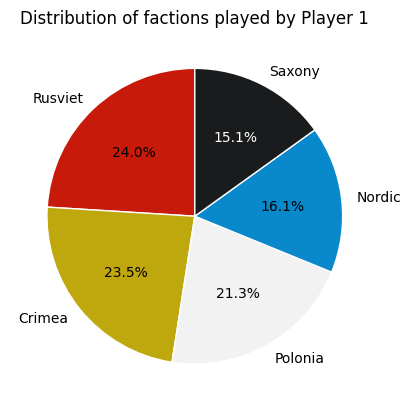

In [20]:
counts = df["J1 Faction"].value_counts()
labels = counts.index
valeurs = counts.values

couleurs_factions = {
    "Polonia" : "#F2F2F2",
    "Crimée" : "#bfa80d",
    "Rusviet" : "#c71a0a",
    "Nordique" : "#0a88cc",
    "Saxe" : "#191b1c"
}

english_factions = {
    "Polonia" : "Polonia",
    "Crimée" : "Crimea",
    "Saxe" : "Saxony",
    "Rusviet" : "Rusviet",
    "Nordique" : "Nordic"
}

colors = [couleurs_factions[label] for label in labels]
english_labels = [english_factions[faction] for faction in labels]

fig, ax = plt.subplots()

patches, texts, autotexts = ax.pie(
    valeurs,
    labels=english_labels,
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"linewidth": 1, "edgecolor": "white"}
)

autotexts[list(labels).index("Saxe")].set_color("white") 

ax.set_title("Distribution of factions played by Player 1")

With this first chart, we can observe that the Rusviet and Crimea factions appear to be advantaged compared to the Saxony and Nordic factions.

We can formulate a hypothesis by contradiction: “The game is balanced, therefore each faction has a 20% probability of winning (100/5).”

⚠️ Important note: In this analysis, we only consider the winners of the selected games, regardless of their skill level or the skill level of their opponents.

We now perform a chi-square test to assess this hypothesis. The significance level is set at 2.5%.

In [21]:
from scipy.stats import chisquare

victoires = df["J1 Faction"].value_counts().sort_index()
expected = [1786]*5

chi2=0
for el in victoires :
    chi2 += ((el-(len(df)/5))**2)/(len(df)/5)

chi22 = chisquare(victoires, expected)
chi22 = chi22.pvalue

print("Chi2 : ", chi2)
print("2nd Chi2:", chi22/100, "%")


Chi2 :  310.70642201834863
2nd Chi2: 4.6403917857945225e-68 %


Since the p-value is well below the chosen significance level, we reject the null hypothesis and conclude that the game is not balanced with respect to factions.

We will now focus on the most successful combinations. Indeed, each player is assigned both a Faction and a Player board. The question is therefore: which of these combinations is the most powerful?

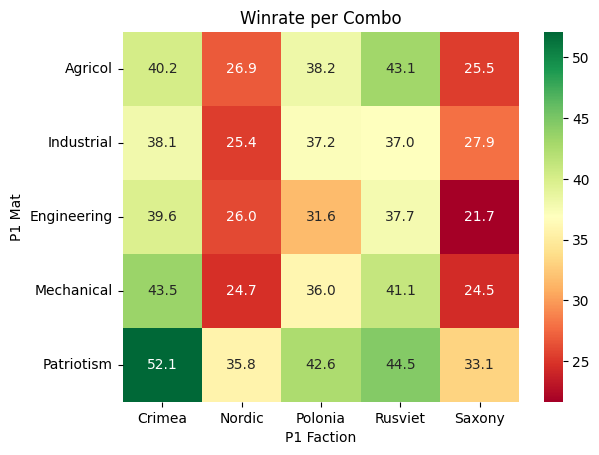

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

victoires = pd.crosstab(df["J1 Mat"], df["J1 Faction"])

english_mat = {
    "Agricole" : "Agricol",
    "Mécanique" : "Mechanical",
    "Industriel" : "Industrial",
    "Ingénierie" : "Engineering",
    "Patriotique" : "Patriotism"
}

victoires = victoires.rename(index=english_mat, columns=english_factions)

total_joues = pd.DataFrame()
for i in range(1, 6):
    temp = df[[f"J{i} Mat", f"J{i} Faction"]].rename(columns={f"J{i} Mat": "Mat", f"J{i} Faction": "Faction"})
    total_joues = pd.concat([total_joues, temp])

cpts_total = pd.crosstab(total_joues["Mat"], total_joues["Faction"])

cpts_total = cpts_total.rename(index=english_mat, columns=english_factions)

winrate = (victoires / cpts_total) * 100

sns.heatmap(winrate, annot=True, fmt=".1f", cmap="RdYlGn")
plt.title("Winrate per Combo")
plt.xlabel("P1 Faction")
plt.ylabel("P1 Mat")
plt.show()

We can thus identify the Crimean–Patriotic combination as the most effective, with a 52.1% win rate.
These results reinforce our earlier findings, highlighting consistently stronger outcomes for combinations that include the Rusviet and Crimean factions.

Finally, we will examine the mechanisms through which players achieve victory, focusing on how the six stars are obtained by Player 1 (the winning player).

In [23]:
import plotly.graph_objects as go

cols = df.columns[68 : 68 + 9 * 5 : 5]

categories = []

english_stars = {
    "Étoile amélioration": "Upgrade Star",
    "Étoile mechas": "Mech Star",
    "Étoile bâtiment": "Structure Star",
    "Étoile recrue": "Enlist Star",
    "Étoile ouvrier": "Worker Star",
    "Étoile objectif": "Objective Star",
    "Étoile combat": "Combat Star",
    "Étoile popu max": "Max Popularity Star",
    "Étoile puissance max": "Max Power Star"
}

for el in cols : 
    nom_francais = (el[3:])
    categories.append(english_stars.get(nom_francais, nom_francais))

factions = df["J1 Faction"].dropna().unique()

etoiles = {}

for faction in factions:
    etoiles[faction] = []

for cat_etoile in cols :
    for faction in factions :
            masque = df["J1 Faction"] == faction
            etoiles[faction].append((df.loc[df["J1 Faction"] == faction, cat_etoile].sum())/masque.sum())

for faction in etoiles:
    etoiles[faction].append(etoiles[faction][0])

categories.append(categories[0])

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=etoiles["Crimée"],
      theta=categories,
      name='Crimea',
      line=dict(color='Yellow')
))

fig.add_trace(go.Scatterpolar(
      r=etoiles["Polonia"],
      theta=categories,
      name='Polonia',
      line=dict(color='Grey')
))

fig.add_trace(go.Scatterpolar(
      r=etoiles["Rusviet"],
      theta=categories,
      name='Rusviet',
      line=dict(color='Red')
))

fig.add_trace(go.Scatterpolar(
      r=etoiles["Nordique"],
      theta=categories,
      name='Nordic',
      line=dict(color='Blue')
))

fig.add_trace(go.Scatterpolar(
      r=etoiles["Saxe"],
      theta=categories,
      name='Saxony',
      line=dict(color='black')
))

fig.update_layout(
     title="Average distribution of stars by faction",
      polar=dict(
      radialaxis=dict(
      visible=True,
      )),
  showlegend=True
)



First of all, to explain some of the results, note that there can be 2 combat stars placed, which is why it is not surprising to see proportions exceeding 1. Additionally, each faction has a "special" ability, and the Saxony faction (Black) can place as many combat and objective stars (2 objective cards are distributed to each player at the start of the game). Therefore, the Saxony faction can approach 1 on the "Objective Star" line.

We can thus observe that a certain strategy emerges, as 6 stars clearly stand out (counting 2 for combat stars). Indeed, combat, objective, worker, recruit, and mecha stars are well represented with proportions above 0.6. In contrast, the "Max Popularity" star is represented at only 0.1 for the Polonia faction, and below 0.05 for the other factions. Similarly, for building stars, the proportion exceeds 0.5 for Polonia but remains minimal for the other factions.

Now, we will focus on points, since sometimes the player who places all 6 stars is not the one who actually wins the game.

How are points counted in Scythe?
At the end of the game, each player falls into one of three popularity tiers. The higher the popularity, the more they multiply the earnings they gain from stars, pairs of remaining resource tokens, and controlled territories. Finally, some additional points are awarded through combinations of building placements (Bonus Tiles).

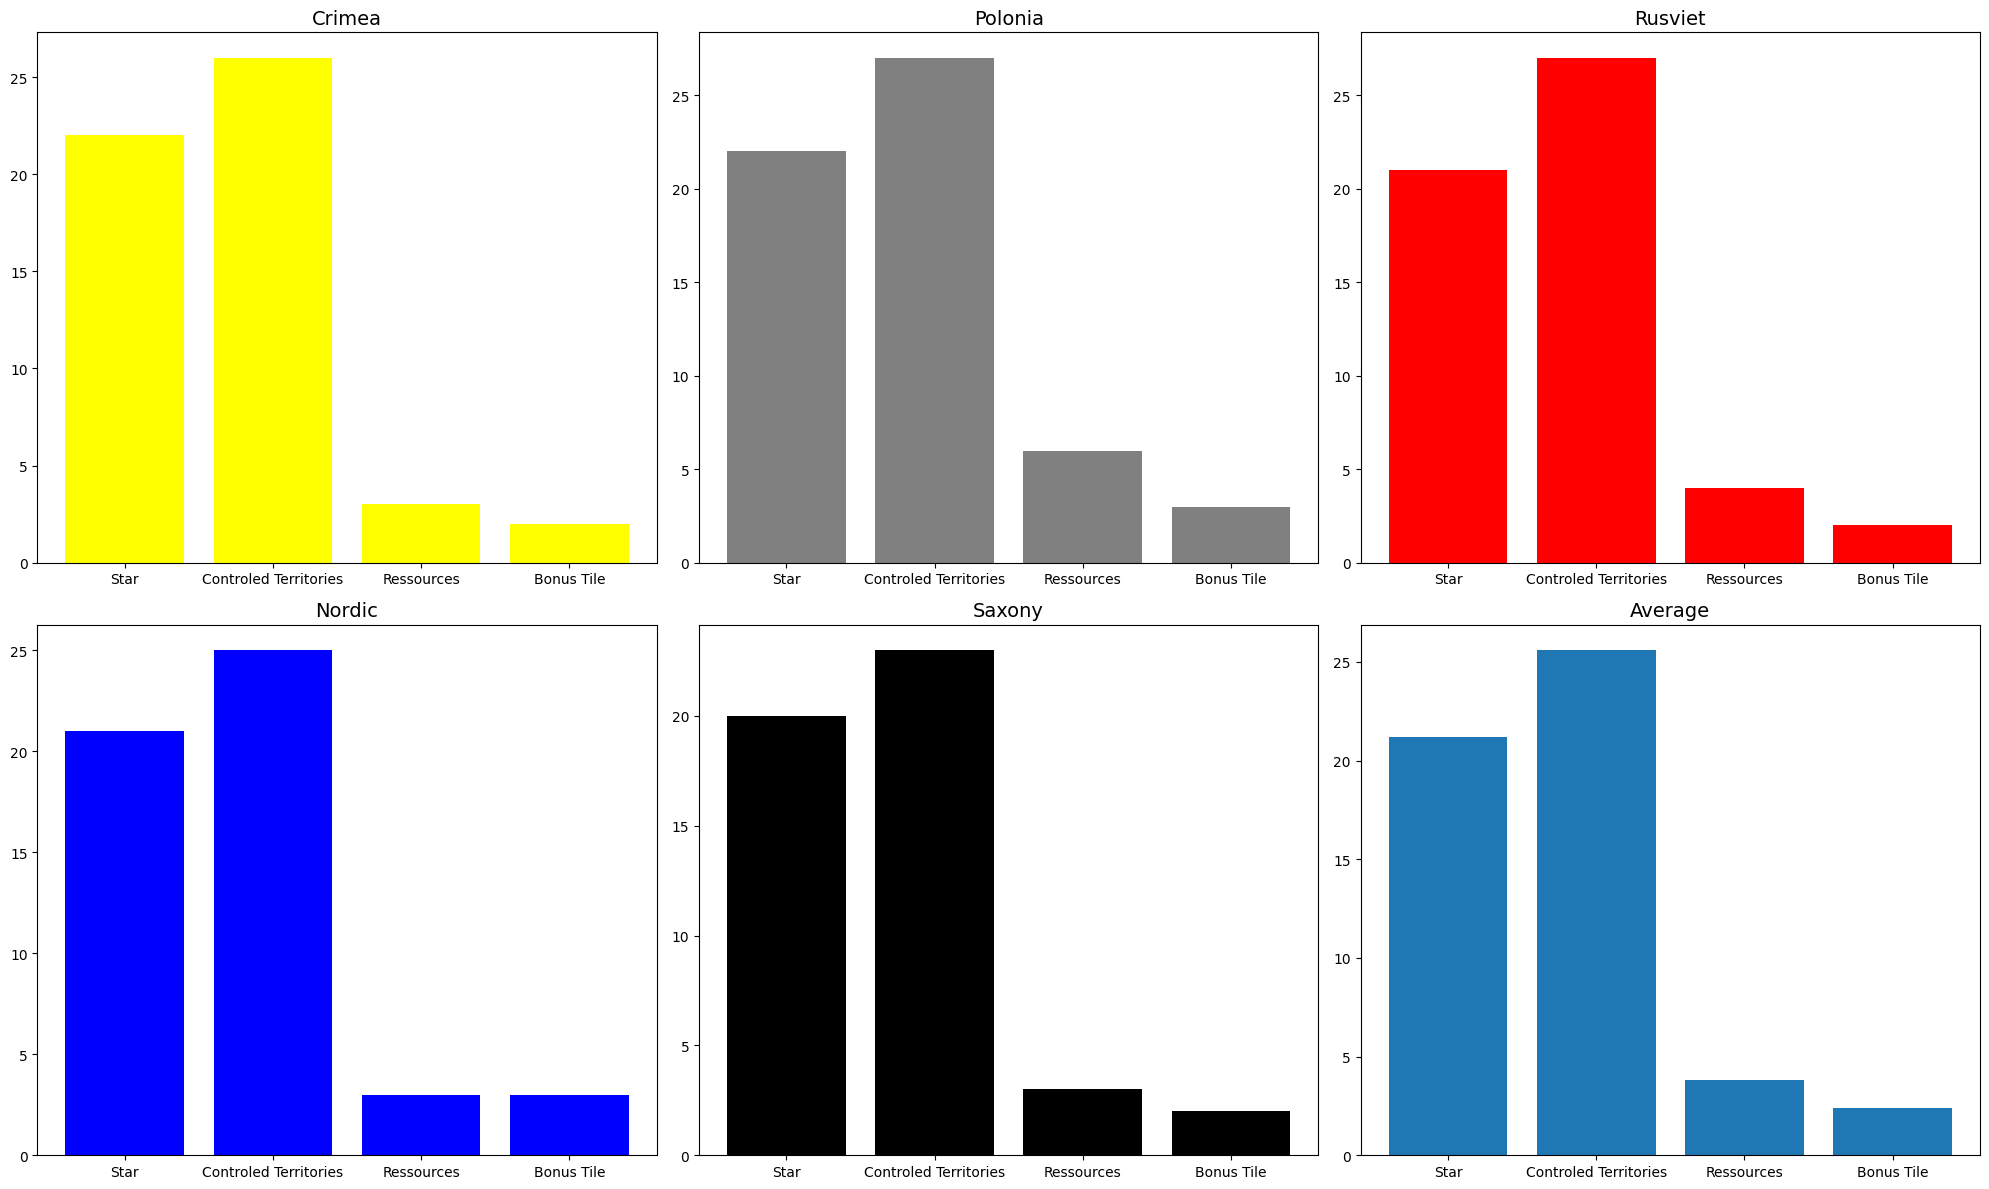

In [24]:
cat_points = ["Star", "Controled Territories", "Ressources", "Bonus Tile"]
colonne_points = ["J1 Pts étoiles", "J1 Pts territoires","J1 Pts ressources","J1 Pts tuile bonus"]

points = {}

for faction in factions :
    points[faction] = []
    for el in colonne_points :
        mask = df["J1 Faction"] == faction
        points[faction].append(int((df.loc[df["J1 Faction"] == faction, el].sum())/mask.sum()))

points["Moyenne"] = []

for x in range(4):
    y = 0
    for faction in factions:
        y+= points[faction][x]
    points["Moyenne"].append((y/5))

fig, axs = plt.subplots(2, 3, figsize=(20,12))

axs[0, 0].bar(cat_points, points["Crimée"], color="Yellow")
axs[0, 0].set_title("Crimea", fontsize=14)
axs[0, 1].bar(cat_points, points["Polonia"], color="grey")
axs[0, 1].set_title("Polonia", fontsize=14)
axs[0, 2].bar(cat_points, points["Rusviet"], color="Red")
axs[0, 2].set_title("Rusviet", fontsize=14)
axs[1, 0].bar(cat_points, points["Nordique"], color="blue")
axs[1, 0].set_title("Nordic", fontsize=14)
axs[1, 1].bar(cat_points, points["Saxe"], color="black")
axs[1, 1].set_title("Saxony", fontsize=14)
axs[1, 2].bar(cat_points, points["Moyenne"])
axs[1, 2].set_title("Average", fontsize=14)

plt.tight_layout()


Nous pouvons donc voir une similitude entre les différentes répartitions de points moyens par factions. Il semble donc important de controler beaucoup de territoires à la fin de partie pour gagner. 

## Conclusion

We were therefore able to analyze and show that the game Scythe is not balanced. There are two factions that are stronger than the others: "Rusviet" and "Crimée." Certain combinations are more powerful and should be prioritized in tournament play (choice of faction and player board).

Furthermore, the most optimal strategy is to aim for the following 6 stars: 2 × combat, 1 × objective, 1 × recruit, 1 × mecha, and 1 × worker.

Finally, the majority of points come from controlling territories, so it is important to expand widely as the game approaches its end.